In [1]:
from __future__ import division
from __future__ import print_function 
import numpy as np
import pandas as pd
from collections import OrderedDict
import argparse
import re
from itertools import combinations
from scipy.stats import beta

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
########################################
## FUNCTIONS
def load_posteriors( f_posteriors, cols_rename = {".alpha1" : "post_alpha" , ".beta1" : "post_beta",
                                                   ".fitted": "post_mean", ".raw" : "freq_mle" },
                   drop_zeroCoverage = True ):
    """
    Inputs
    ------
        f_posteriors - OrderedDict keys are conditions values are file names
        cols_rename - dictionary keys are columns of files to load values and new names for the loaded columns
        drop_zeroCoverage  - bool
    Returns:
    -------
        df_post - dataframe
    """
    df_list = []
    for c, f in f_posteriors.items():
        print("\tloading file {} for condition {}".format(f,c))
        df = pd.read_csv(f, sep = "\t", header = 0, index_col = [0,1], usecols = ["seq" , "idx"] + list(cols_rename.keys()) )
        df = df.rename(columns = cols_rename)
        df_list.append(df)
    df_post = pd.concat(df_list , keys =  f_posteriors.keys() , axis = 1)
    if drop_zeroCoverage:
        print("\tRemoving CpG C\'s not covered in >= 1 condition")
        print( "\tn not covered by conition")
        print(df_post.isna().sum(axis=0).groupby(level = 0).apply(lambda x: x.iloc[0]))
        no_coverage = df_post.isna().any(axis = 1)
        print("\ttotal not covered {}".format(no_coverage.sum() ) )
        df_post = df_post.loc[~ no_coverage ,: ].copy()
        print("\ttotal remaining covered {}".format(df_post.shape[0]) )            
    return df_post

def load_priors(f_priors):
    """
    Input:
    ------
        f_posteriors - OrderedDict keys are conditions values are file names
    """
    df_pri = pd.DataFrame( np.zeros( (2,len(f_priors)), dtype = float),
                          index = ["alpha" , "beta"]  , 
                          columns = list(f_priors.keys())  ) 
    for c, fname in f_priors.items():
        f = open(fname,'r')
        lines = f.readlines()
        f.close()
        alpha = [ re.search( 'alpha\s+([\d|\.]+)', x).group(1) for x in lines if  re.search( 'alpha\s([\d|\.]+)', x) is not None ]
        if len(alpha) >1:
            raise Exception("found more than one match for alpha")
        else:
            df_pri.loc["alpha" , c] = float(alpha[0])
        
        beta = [ re.search( 'beta\s+([\d|\.]+)', x).group(1) for x in lines if re.search( 'beta\s+([\d|\.]+)', x) is not None ]
        if len(beta) >1:
            raise Exception("found more than one match for beta")
        else:
            df_pri.loc["beta" , c] = float(beta[0])
    betaMean = df_pri.loc["alpha", :].divide( df_pri.loc["alpha", :] +  df_pri.loc["beta", :] )
    betaMean.name = "prior_mean"
    df_pri = pd.concat([df_pri, betaMean.to_frame().transpose()], axis =0)  ## hack
    return df_pri

##################
## PLOT
def plot_priorFit(df_post, df_pri, fig_width = 12, ax_height = 3, xlabel = "p mCpG", bins = 100  ):
    
    
    ncols = 2
    nrows = -(-len(conditions) //ncols)
    fig, axes = plt.subplots(nrows= nrows , ncols = ncols, figsize = (fig_width, ax_height*nrows))

    for c, ax in zip(conditions, np.ravel(axes)):
        ax.hist(df_post.loc[:, (c , "freq_mle" )].values , bins = bins, density = True, histtype =  'step', label = "mle-empirical" )
        a, b = df_pri.loc[ ["alpha" , "beta"], c]
        rv = beta(a, b)
        x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.9999995, a, b), 1000)
        ax.plot(x, beta.pdf(x, a, b), 'r-', lw=5, alpha=0.6, label='prior pdf')
        ax.set_yscale("log")
        ax.set_title(c + ", alpha: {:.1f}, beta: {:.1f}".format(a,b))
        ax.set_xlabel(xlabel)
        ax.legend(loc = 1)

    fig.tight_layout()
    return fig

In [11]:
########################################
## Parse CMD line

parser= argparse.ArgumentParser(description= "Check beta prior fit")
parser.add_argument("-c", "--conditions", help = "comma separated list of condition names")
parser.add_argument("--f_prior" , help = "comma separated list with prior parameters")
parser.add_argument("--f_posterior" , help = "comma separated list of file names, columns must include XX,XX ...")
parser.add_argument("-o" , "--fo" , help = "basename for outputs")

exampleArgs = "-c 3A1,3A2,3B1,3A13L,3A23L,3B13L-d1 \
--f_prior dME_bayes_eBB_3A1.prior.txt,dME_bayes_eBB_3A2.prior.txt,\
dME_bayes_eBB_3B1.prior.txt,dME_bayes_eBB_3A13L.prior.txt,\
dME_bayes_eBB_3A23L.prior.txt,dME_bayes_eBB_3B13L-d1.prior.txt \
--f_posterior dME_bayes_eBB_3A1.posterior.tsv,dME_bayes_eBB_3A2.posterior.tsv,\
dME_bayes_eBB_3B1.posterior.tsv,dME_bayes_eBB_3A13L.posterior.tsv,\
dME_bayes_eBB_3A23L.posterior.tsv,dME_bayes_eBB_3B13L-d1.posterior.tsv \
-o betaPriorFit_freqMLE.empricial.png"
args = parser.parse_args(exampleArgs.split())
conditions = args.conditions.split(",")
f_prior = OrderedDict([(c,  x) for c , x in zip(conditions, args.f_prior.split(",") )])  
f_posterior = OrderedDict([(c , x) for c , x in zip(conditions, args.f_posterior.split(",") )])  

In [4]:
df_post = load_posteriors(f_posterior)
df_pri = load_priors(f_prior)

	loading file dME_bayes_eBB_3A1.posterior.tsv for condition 3A1
	loading file dME_bayes_eBB_3A2.posterior.tsv for condition 3A2
	loading file dME_bayes_eBB_3B1.posterior.tsv for condition 3B1
	loading file dME_bayes_eBB_3A13L.posterior.tsv for condition 3A13L
	loading file dME_bayes_eBB_3A23L.posterior.tsv for condition 3A23L
	loading file dME_bayes_eBB_3B13L-d1.posterior.tsv for condition 3B13L-d1
	Removing CpG C's not covered in >= 1 condition
	n not covered by conition
3A1         1269
3A13L       1899
3A2          783
3A23L       1111
3B1          777
3B13L-d1    1725
dtype: int64
	total not covered 3569
	total remaining covered 519693


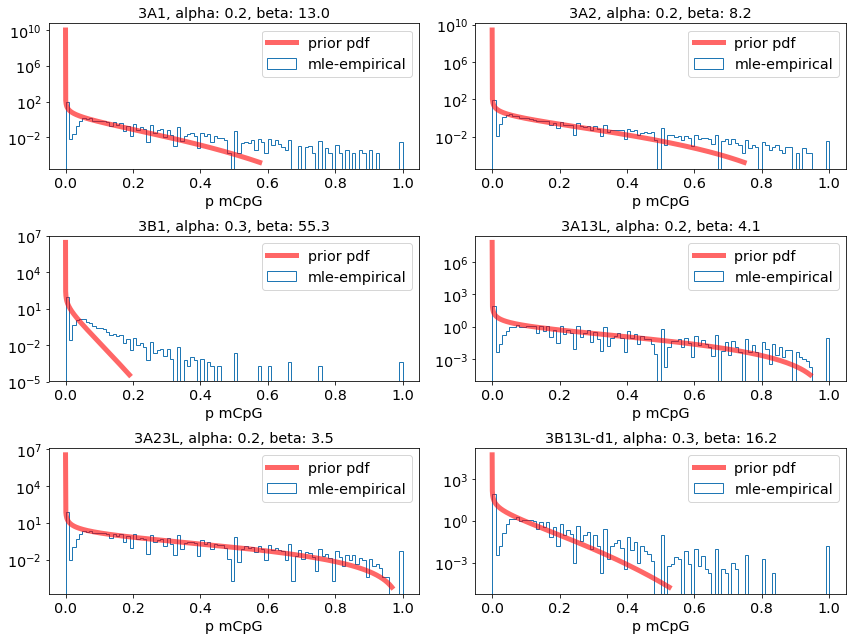

In [13]:
fig = plot_priorFit(df_post, df_pri, fig_width = 12, ax_height = 3, xlabel = "p mCpG", bins = 100  )
fig.savefig(args.fo , format = "png" , box_inches = "tight")

In [14]:
print(conditions)

['3A1', '3A2', '3B1', '3A13L', '3A23L', '3B13L-d1']
